In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain, product
from label_it.model.CM_Label import CM_Label
from label_it.model.SVD_Label import SVD_Label
from label_it.model.NMF_Label import NMF_Label
from label_it.model.WE_Label import WE_Label
from label_it.model.DNN_Label import DNN_Label

import label_it.utils as utils

# Setting 

In [7]:
FD_DATA = './data/'
FD_WEIGHT = './weight/'
FN_DATA = FD_DATA + 'data_sample.csv'
# FN_WEIGHT = FD_WEIGHT + 'weight_CM.p'
# FN_WEIGHT = FD_WEIGHT + 'weight_SVD.p'
# FN_WEIGHT = FD_WEIGHT + 'weight_NMF.p'
# FN_WEIGHT = FD_WEIGHT + 'weight_WE.p'
FN_WEIGHT = FD_WEIGHT + 'weight_DNN.p'

# Load Data

In [3]:
df = pd.read_csv(FN_DATA, encoding='latin-1')
N = df.shape[0]

# Map label to label description 
map_l2d = dict(df.groupby(by='LABEL')['LABEL_DESC'].first().reset_index().values.tolist())

df.columns, N

(Index(['DESC', 'LABEL', 'LABEL_DESC'], dtype='object'), 8095)

# Prepare data

In [4]:
# x = df.DESC.str.split().values
# y = df.LABEL.str.split().values

# universe_desc = set(chain.from_iterable(x))
# universe_label = set(chain.from_iterable(y))
# print(len(universe_desc), len(universe_label))

# # Break down pair of (word, word)
# x, y = zip(*[ [[w1], [w2]] for arr_x, arr_y in zip(x, y) for w1, w2 in product(arr_x, arr_y) ])
# x = utils.asarray_of_list(list(x))     # Make sure x is ndarray(List)
# y = utils.asarray_of_list(list(y))     # Make sure y is ndarray(List)

x = df.DESC.str.split().values
y = df.LABEL.values
y = utils.asarray_of_list([ [v] for v in y ])     # Make sure y is ndarray(List)

universe_desc = set(chain.from_iterable(x))
universe_label = set(chain.from_iterable(y))
print(len(universe_desc), len(universe_label))

5919 356


# Train CM Labeller

In [5]:
param_optim = {}

# Create model
model = CM_Label()

# Build
model.build(universe_x=universe_desc, universe_y=universe_label)

# Compile
model.compile()

# Fit
model.fit(x, y, verbose=True)

# Save
model.save_model(FN_WEIGHT)

# Load
model.load_model(FN_WEIGHT)

# Inference
# y_pred = model.predict(x, n_best=1)

# Evaluate
# perc_match = (y_pred == y).sum() / y.shape[0]
# print('train acc {}'.format(perc_match))

# Train SVD Labeller

Explained variance: 0.9986991647918926
train acc 0.8190240889437924


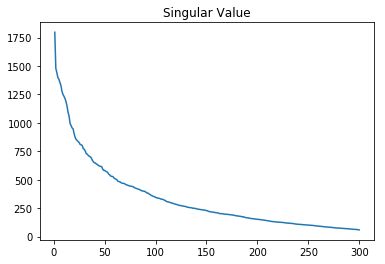

In [8]:
# param_optim = {'n_components': 23}
param_optim = {'n_components': 300,
               'tfidf': True}

# Create model
model = SVD_Label(**param_optim)

# Build
model.build(universe_x=universe_desc, universe_y=universe_label)

# Compile
model.compile()

# Fit
model.fit(x, y, verbose=True)

# Save
model.save_model(FN_WEIGHT)

# Load
model.load_model(FN_WEIGHT)

# Inference
y_pred = model.predict(x)

# Evaluate
perc_match = (y_pred == y).sum() / y.shape[0]
print('train acc {}'.format(perc_match))


# Train NMF Labeller

In [5]:
# param_optim = {'n_components': 70}
param_optim = {'n_components': 300,
               'tfidf': True}

# Create model
model = NMF_Label(**param_optim)

# Build
model.build(universe_x=universe_desc, universe_y=universe_label)

# Compile
model.compile()

# Fit
model.fit(x, y, verbose=True)

# Save
model.save_model(FN_WEIGHT)

# Load
model.load_model(FN_WEIGHT)

# Inference
y_pred = model.predict(x)

# Evaluate
perc_match = (y_pred == y).sum() / y.shape[0]
print('train acc {}'.format(perc_match))


Recon error: 421.39832504173506, Raw matrix norm: 1797.2056171638756
train acc 0.6864731315626931


# Train WE Labeller

In [6]:
# param_optim = {'embedding_size': 30,
#                'num_sampled': 5}
param_optim = {'embedding_size': 50,
               'num_sampled': 50,
               'tfidf': True}

# Create model
model = WE_Label(vocabulary_size=len(universe_desc),
                 label_size=len(universe_label),
                 **param_optim,
                 )

# Build
model.build(universe_x=universe_desc, universe_y=universe_label)

# Compile
model.compile(num_sampled=param_optim['num_sampled'])     # num_samples:   no. of negative samples in tf.nn.nce_loss


model.fit(x, y, verbose=True)

# Save
model.save_model(FN_WEIGHT)

# Load
model.load_model(FN_WEIGHT)

# Inference
y_pred = model.predict(x)

# Evaluate
perc_match = (y_pred == y).sum() / y.shape[0]
print('train acc {}'.format(perc_match))
        

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.
Initialized
Save BEST model at step 160 (40.668).........] - ETA: 17:22 - loss: 76.6884 - val loss: 81.6027 - accuracy: 0.0000e+00 - val accuracy: 0.0037   WARNING:tensorflow:From /home/kumamon/.conda/envs/dev/lib/python3.7/site-packages/tensorflow/python/training/saver.py:966: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
 17000/100000 [====>.........................] - ETA: 6:13 - loss: 0.2340 - val loss: 1.5113 - accuracy: 0.9375 - val accuracy: 0.8022
Plateau reached.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ckpt/W

# Train DNN Labeller

In [8]:
# param_optim = {'embedding_size': 30,
#                'num_sampled': 5}
param_optim = {'param_layer': (50,),
               'num_sampled': 50,
               'tfidf': True}

# Create model
model = DNN_Label(vocabulary_size=len(universe_desc),
                 label_size=len(universe_label),
                 **param_optim)

# Build
model.build(universe_x=universe_desc, universe_y=universe_label)

# Compile
model.compile(num_sampled=param_optim['num_sampled'])     # num_samples:   no. of negative samples in tf.nn.nce_loss


model.fit(x, y, verbose=True)

# Save
model.save_model(FN_WEIGHT)

# Load
model.load_model(FN_WEIGHT)

# Inference
y_pred = model.predict(x)

# Evaluate
perc_match = (y_pred == y).sum() / y.shape[0]
print('train acc {}'.format(perc_match))
        

Initialized
 16500/100000 [===>..........................] - ETA: 6:10 - loss: 0.3615 - val loss: 1.6349 - accuracy: 0.9375 - val accuracy: 0.7763
Plateau reached.
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-6560

Reduce lr to 0.0005000000237487257
 26600/100000 [======>.......................] - ETA: 5:19 - loss: 0.3548 - val loss: 1.4592 - accuracy: 0.9062 - val accuracy: 0.7577
Plateau reached.
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-6560

Reduce lr to 0.0002500000118743628
 36700/100000 [==========>...................] - ETA: 4:33 - loss: 0.8067 - val loss: 1.5192 - accuracy: 0.9688 - val accuracy: 0.7775
Plateau reached.
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-6560

Reduce lr to 0.0001250000059371814
 47200/100000 [=============>................] - ETA: 3:46 - loss: 0.2594 - val loss: 1.4912 - accuracy: 0.9688 - val accuracy: 0.7676
Plateau reached.
INFO:tensorflow:Restoring parameters from ./ckpt/WE_Label-6560

Reduce lr to 6.2500